In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import correlate2d, find_peaks
from skimage.feature.peak import peak_local_max
from scipy.stats import circmean

# Function to simulate a grid cell rate map
def simulate_grid_cell(size=100, spacing=20, angle_deg=0):
    angle = np.deg2rad(angle_deg)

    x = np.linspace(-size / 2, size / 2, size)
    y = np.linspace(-size / 2, size / 2, size)
    X, Y = np.meshgrid(x, y)

    # Create three cosine gratings with 60° rotational symmetry
    grating1 = np.cos(2 * np.pi * (X * np.cos(angle) + Y * np.sin(angle)) / spacing)
    grating2 = np.cos(2 * np.pi * (X * np.cos(angle + np.deg2rad(60)) + Y * np.sin(angle + np.deg2rad(60))) / spacing)
    grating3 = np.cos(2 * np.pi * (X * np.cos(angle + np.deg2rad(120)) + Y * np.sin(angle + np.deg2rad(120))) / spacing)

    # Combine gratings to form hexagonal grid pattern
    rate_map = grating1 + grating2 + grating3
    rate_map = gaussian_filter(rate_map, sigma=2)  # Smooth the rate map
    return rate_map

# Function to compute 2D autocorrelogram
def compute_autocorrelogram(rate_map):
    autocorr = correlate2d(rate_map, rate_map, mode='full')
    autocorr = autocorr / np.max(autocorr)  # Normalize
    return autocorr


# Function to find peaks with constraints
def compute_ring(autocorr):
    center = np.array(autocorr.shape) // 2
    peaks = peak_local_max(
            np.nan_to_num(autocorr),
            min_distance=8,
            exclude_border=True,
        )
    distances = np.array([np.linalg.norm(center - peak) for peak in peaks])
    sorted = np.argsort(distances)[1:7]
    peaks = peaks[sorted]
    peaks_old = peaks.copy()
    distances = distances[sorted]
    distances = np.array(
        [np.linalg.norm(center - peak) for peak in peaks]
            )
    # Define the ring size
    mean_distance = np.mean(distances)
    inner_radius = mean_distance * 0.5
    outer_radius = mean_distance * 1.25

    # Extract a ring around the center
    y, x = np.ogrid[: autocorr.shape[0], : autocorr.shape[1]]
    mask = (x - center[1]) ** 2 + (y - center[0]) ** 2 >= inner_radius**2
    mask &= (x - center[1]) ** 2 + (y - center[0]) ** 2 <= outer_radius**2
    ring = np.where(mask, autocorr, np.nan)

    oris = []
    for peak in peaks_old:
        angle = np.rad2deg(np.arctan2(center[0]-peak[1], 
                                      center[1]-peak[0]))
        ori = angle%60
        oris.append(ori)
    oris = np.array(oris)

    ori = circmean(oris, high=60, low=0)

    return ring, mean_distance, ori

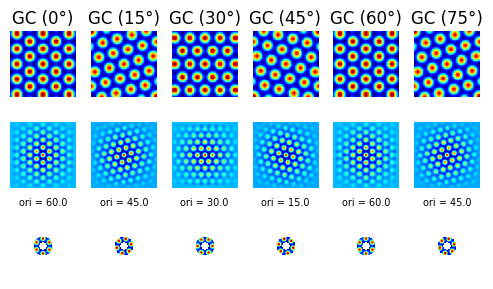

In [23]:

# Simulate original and rotated grid cell rate maps
rate_map1 = simulate_grid_cell(angle_deg=0)
rate_map2 = simulate_grid_cell(angle_deg=15)
rate_map3 = simulate_grid_cell(angle_deg=30)
rate_map4 = simulate_grid_cell(angle_deg=45)
rate_map5 = simulate_grid_cell(angle_deg=60)
rate_map6 = simulate_grid_cell(angle_deg=75)

# Compute their autocorrelograms
autocorr1 = compute_autocorrelogram(rate_map1)
autocorr2 = compute_autocorrelogram(rate_map2)
autocorr3 = compute_autocorrelogram(rate_map3)
autocorr4 = compute_autocorrelogram(rate_map4)
autocorr5 = compute_autocorrelogram(rate_map5)
autocorr6 = compute_autocorrelogram(rate_map6)

ring1, scale1, ori1 = compute_ring(autocorr1)
ring2, scale2, ori2 = compute_ring(autocorr2)
ring3, scale3, ori3 = compute_ring(autocorr3)
ring4, scale4, ori4 = compute_ring(autocorr4)
ring5, scale5, ori5 = compute_ring(autocorr5)
ring6, scale6, ori6 = compute_ring(autocorr6)

# Plot the results
fig, axes = plt.subplots(3, 6, figsize=(5, 3))

axes[0, 0].set_title('GC (0°)')
axes[0, 1].set_title('GC (15°)')
axes[0, 2].set_title('GC (30°)')
axes[0, 3].set_title('GC (45°)')
axes[0, 4].set_title('GC (60°)')
axes[0, 5].set_title('GC (75°)')


# Plot original and rotated rate maps
axes[0, 0].imshow(rate_map1, cmap='jet', interpolation='nearest')
axes[0, 1].imshow(rate_map2, cmap='jet', interpolation='nearest')
axes[0, 2].imshow(rate_map3, cmap='jet', interpolation='nearest')
axes[0, 3].imshow(rate_map4, cmap='jet', interpolation='nearest')
axes[0, 4].imshow(rate_map5, cmap='jet', interpolation='nearest')
axes[0, 5].imshow(rate_map6, cmap='jet', interpolation='nearest')

# Plot autocorrelograms
axes[1, 0].imshow(autocorr1, cmap='jet', interpolation='nearest')
axes[1, 1].imshow(autocorr2, cmap='jet', interpolation='nearest')
axes[1, 2].imshow(autocorr3, cmap='jet', interpolation='nearest')
axes[1, 3].imshow(autocorr4, cmap='jet', interpolation='nearest')
axes[1, 4].imshow(autocorr5, cmap='jet', interpolation='nearest')
axes[1, 5].imshow(autocorr6, cmap='jet', interpolation='nearest')

# Plot autocorrelograms
axes[2, 0].imshow(ring1, cmap='jet', interpolation='nearest')
axes[2, 1].imshow(ring2, cmap='jet', interpolation='nearest')
axes[2, 2].imshow(ring3, cmap='jet', interpolation='nearest')
axes[2, 3].imshow(ring4, cmap='jet', interpolation='nearest')
axes[2, 4].imshow(ring5, cmap='jet', interpolation='nearest')
axes[2, 5].imshow(ring6, cmap='jet', interpolation='nearest')

axes[2, 0].set_title(f'ori = {np.round(ori1, decimals=2)}', fontsize=7)
axes[2, 1].set_title(f'ori = {np.round(ori2, decimals=2)}', fontsize=7)
axes[2, 2].set_title(f'ori = {np.round(ori3, decimals=2)}', fontsize=7)
axes[2, 3].set_title(f'ori = {np.round(ori4, decimals=2)}', fontsize=7)
axes[2, 4].set_title(f'ori = {np.round(ori5, decimals=2)}', fontsize=7)
axes[2, 5].set_title(f'ori = {np.round(ori6, decimals=2)}', fontsize=7)

for ax in axes.flatten():
    ax.axis('off')
plt.tight_layout()
plt.show()
